# Revisiting the time dependence of SEI growth
## Peter Attia, last updated April 11, 2020
This notebook is used to explore the time dependence of SEI growth.

Note that this notebook uses asymptotic, symmetric, approximate CIs instead of profile-likelihood asymmetric CIs. The other notebook in this repository will generate the same figures but with the profile-likelihood CIs. However, because the results are essentially equivalent, I present the CIs using the standard $\pm$ notation for simplicity.

In [1]:
import glob
import os
from collections import namedtuple
import inflect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats.distributions import t
from sklearn.metrics import mean_squared_error, r2_score

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 6
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Preliminaries

Set $\alpha$ for 95% CI:

In [3]:
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

Create tval wrapper:

In [4]:
def tval(alpha, n, p):
    dof = max(0, n - p) # degrees of freedom
    tval = t.ppf(1 - alpha/2, dof)
    return tval

Define wrapper functions for `curve_fit` that returns both the 95% CIs and either $R^2$ or $R^2_{adj}$.
See [here](http://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/) for 95% CI reference (also cross-referenced with MATLAB and R's 95% CI calculations)
and [here](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2) for $R^2_{adj}$ reference

In [5]:
def adj_r_squared(r_squared, n, p):
    return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

def curve_fit_with_r_squared(f, xdata, ydata, maxfev=10000):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=maxfev)
    
    n = len(xdata)
    p = len(popt)
    CIs = tval(alpha, n, p) * np.diag(pcov)**0.5
    
    y_pred = f(xdata, *popt)
    r_sq = r2_score(ydata, y_pred)
    
    return popt, CIs, r_sq

def curve_fit_with_adj_r_squared(f, xdata, ydata, maxfev=10000):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=maxfev)

    n = len(xdata)
    p = len(popt)
    CIs = tval(alpha, n, p) * np.diag(pcov)**0.5
    
    y_pred = f(xdata, *popt)
    r_sq = r2_score(ydata, y_pred)
    adj_r_sq = adj_r_squared(r_sq, n, p)
    
    return popt, CIs, adj_r_sq

## Illustration
First, we illustrate how $t^{0.5}$ models can "look good" but still not capture the true functional form.

We primarily explore the three functional forms below: $y = ax^{0.5}+b$, $y = ax^{b}$, and $y = ax^{b}+c$.

In [6]:
def t_onehalf(x, a, b):
    return a * x**0.5 + b

def power1(x, a, b):
    return a * x**b

def power2(x, a, b, c):
    return a * x**b + c

Here we illustrate $ y=ax^{0.5}+b $ fits to a $ y=ax^b $ function, along with its residual:

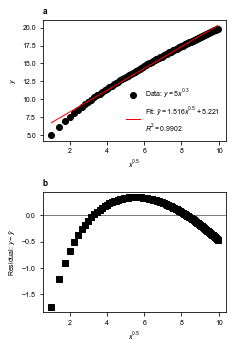

In [7]:
exponent = 0.3

x = np.arange(1, 100) # example data
sqrt_x = np.sqrt(x)
y = 5 * (x**exponent)

popt, CIs, r_squared = curve_fit_with_r_squared(t_onehalf, x, y)

plt.subplots(figsize=(fig_width, fig_height*2), nrows=2)
plt.subplot(211)
plt.title('a', loc='left', weight='bold')

plt.plot(sqrt_x, y, 'ko',
         label='Data: ' + r'$y=5x^{' + str(exponent) + '}$')
plt.plot(sqrt_x, t_onehalf(x, *popt), 'r-',
         label='Fit: ' + r'$\hat{y}=%5.3fx^{0.5} + %5.3f$' % tuple(popt)
         + '\n' + r'$R^2=%3.4f$' %(r_squared))
plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'$y$')
plt.legend()

plt.subplot(212)
plt.title('b', loc='left', weight='bold')

plt.axhline(0, color='tab:gray')
plt.plot(x**0.5, y-t_onehalf(x, *popt), 'ks')

plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'Residual: $y-\hat{y}$')

plt.tight_layout()
plt.savefig('figures/example.eps', bbox_inches='tight', format='eps')

## WebPlotDigitizer test
The data from the C/10, 30&deg;C series of Figure 7 of [Smith et al.](https://doi.org/10.1149/1.3557892) was extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) using three different extraction techniques from their tool. The figure is reproduced here:<br>
<img src="smith/Smith_et_al_2011_Fig7.png" width="400">

In [8]:
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_30degC_Cover10*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
Smith_30C_data = []
data_shape = np.genfromtxt(csvs[0], delimiter=',').shape
x = np.zeros((data_shape[0], 3))
y = np.zeros((data_shape[0], 3))

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv, delimiter=',')
    Smith_30C_data.append(d)
    x[:,k] = d[:,0]
    y[:,k] = d[:,1]

Plot the three extractions together:

Text(0, 0.5, '$Q_{irr}$ (mAh/g)')

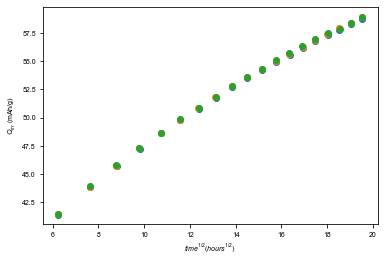

In [9]:
for d in Smith_30C_data:
    plt.plot(d[:,0], d[:,1], 'o')
plt.xlabel(r'$time^{1/2} (hours^{1/2})$')
plt.ylabel(r'$Q_{irr}$ (mAh/g)')

Triplicate extractions look very similar. Next. we determine the relative standard error (rse) to quantify the extraction error:

Mean relative standard error = 0.095%
Max relative standard error = 0.151%


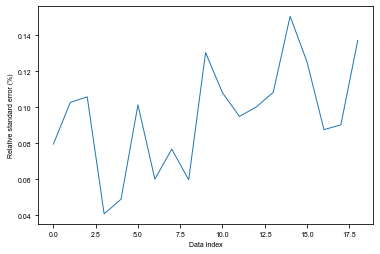

In [10]:
means = np.mean(y, axis=1)
se = 1.96*np.std(y, axis=1)/np.sqrt(3)
rse = se/means*100
plt.plot(rse)
plt.xlabel('Data index')
plt.ylabel('Relative standard error (%)')
print('Mean relative standard error = {:.3f}%'.format(np.mean(rse)))
print('Max relative standard error = {:.3f}%'.format(np.max(rse)))

Extraction errors are quite low. For now we'll assume we can accurately extract the data, although of course there could be systematic extraction errors (we don't have the true values for the true quantification).

## Literature data re-analysis

In this section, we systematically reanalyze many purported $ t^{0.5} $ fits from literature.

### Helper functions

We first define a set of helper functions for loading data, plotting, etc:

In [11]:
def sortKeyFunc(s):
    return os.path.basename(s)

Create dataset loading function:

In [12]:
def load_dataset(author):
    csvs = glob.glob(author+'/'+author+'_et_al*.{}'.format('csv')) #two-column array
    csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

    print(csvs)

    data = []

    for k, csv in enumerate(csvs):
        d = np.genfromtxt(csv,delimiter=',')
        data.append(d)
        
    return data

Create `Labels` `namedtuple` as a container for dataset-specific properties: 

In [13]:
Labels = namedtuple('Labels', ['legend_labels', 'x_label', 'y_label', 'dataset_name',
                               'y_symbol', 'y_symbol_pred', 'y_unit', 'switch_xy', 'square_x'])

Create helper function for plotting the raw data:

In [14]:
def plot_raw_data_subplot(data, labels, markers):
    
    x_max = 0
    
    # account for different types of raw data
    exponent = 1
    if labels.square_x:
        exponent = 2
    
    # legend tweaking based on number of series
    colon_str = ''
    if len(data) > 1:
        colon_str = ':\n'
    
    for k, dataset in enumerate(data):
        
        x = dataset[:,0]**exponent
        y = dataset[:,1]
        
        if labels.switch_xy:
            x, y = y, x
        
        x_max = np.max([np.max(x), x_max])

        popt1, CIs1, adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
        popt2, CIs2, adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
        popt3, CIs3, adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
                
        # Rounding
        prec2 = -int(np.floor(np.log10(CIs2[1])))
        try:
            prec3 = -int(np.floor(np.log10(CIs3[1])))
        except ValueError: # CI = nan
            prec3 = 0
        
        label = labels.legend_labels[k] + colon_str \
        + r'$' + labels.y_symbol_pred + '=%.3gt^{0.5} %+.3g$' % tuple(popt1) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_1 + '\n' \
        + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec2)+'f \pm %.'+str(prec2)+'f}$') % tuple(np.append(popt2, CIs2[1])) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_2 + '\n' \
        + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec3)+'f \pm %.'+str(prec3)+'f} %+.3g$') % tuple(np.insert(popt3, 2, CIs3[1])) \
        + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_3
        
        # special case for carbon black data
        if popt3[0] > 1000:
            label = labels.legend_labels[k] + colon_str \
            + r'$' + labels.y_symbol_pred + '=%.3g t^{0.5} %+.3g$' % tuple(popt1) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_1 + '\n' \
            + r'$' + labels.y_symbol_pred + ('=%.3gt^{%.'+str(prec2)+'f \pm %.'+str(prec2)+'f}$') % tuple(np.append(popt2, CIs2[1])) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_2 + '\n' \
            + r'$' + labels.y_symbol_pred + ('=%.4g t^{%.'+str(prec3)+'f \pm %.'+str(prec3)+'f} %+.4g$') % tuple(np.insert(popt3, 2, CIs3[1])) \
            + ', ' + r'$R_{adj}^2=%.4f}$' % adj_r2_3
        
        plt.plot(x, y, linestyle='None', marker=markers[k], label=label, color=colors[k])

    plt.xlabel(labels.x_label)
    plt.ylabel('{} {}'.format(labels.y_label, labels.y_unit))
    
    # Define standard xlim
    print('x_max of dataset = {}'.format(x_max))
    xlim_min = -0.1 * x_max
    xlim_max = 1.15 * x_max
    plt.xlim((xlim_min, xlim_max))
    
    return (xlim_min, xlim_max)

Create helper function for plotting residuals:

In [15]:
def plot_residual_subplot(data, index, labels, xlim, marker):
    
    colors = cm.viridis(np.linspace(0, 1, 4))
    colors = colors[:,0:3]
    
    exponent = 1
    if labels.square_x:
        exponent = 2
    
    x = data[index][:,0]**exponent
    y = data[index][:,1]
    
    if labels.switch_xy:
        x, y = y, x

    popt1, CIs1, adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2, CIs2, adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3, CIs3, adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    
    plt.axhline(0,color='tab:gray')
    
    plt.plot(x, y - t_onehalf(x, *popt1), marker, color = colors[2, :], label=r'$y=ax^{0.5}+b$')
    plt.plot(x, y - power1(x, *popt2), marker, color = colors[1,:], label=r'$y=ax^{b}$')
    plt.plot(x ,y - power2(x, *popt3), marker, color = colors[0,:], label=r'$y=ax^{b}+c$')
             
    y_label = 'Residual: '+ r'$' + labels.y_symbol +'-' + labels.y_symbol_pred + '$' + ' ' + labels.y_unit
    
    plt.xlabel(labels.x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim)
    
    # annoying hack for Wright dataset
    legend_loc = 'best'
    if labels.dataset_name == 'Wright':
        legend_loc = 'lower right'
        
    plt.legend(title = labels.legend_labels[index], loc=legend_loc)

Helper function for plotting raw data in subplot (a), plotting the residuals of the first and last series in subplots (b) and (c), respectively, and plotting a large legend in the top right quadrant.

In [16]:
def plot_dataset(data, labels):
    
    # Find number of datasets
    n_datasets = len(data)
    
    # Initialize figure
    plt.figure(figsize=(fig_width*2, fig_height*2.5))

    # (a): Plot raw data
    ax = plt.subplot(221)
    plt.title('a', loc='left', weight='bold')
    xlim = plot_raw_data_subplot(data, labels, markers)

    # (b): Plot first series
    plt.subplot(223)
    plt.title('b', loc='left', weight='bold')
    plot_residual_subplot(data, 0, labels, xlim, markers[0])

    # (c): Plot last series
    plt.subplot(224)
    plt.title('c', loc='left', weight='bold')
    plot_residual_subplot(data, n_datasets-1, labels, xlim, markers[-1])

    plt.tight_layout()
    
    ax.legend(bbox_to_anchor=(0.55, 0.75), loc='center left', labelspacing=1.5,
              bbox_transform=plt.gcf().transFigure)
    
    # Save
    figure_filename = 'figures/{}.eps'.format(labels.dataset_name)
    plt.savefig(figure_filename, bbox_inches='tight', format='eps')

### Broussely et al

[Link to paper](https://doi.org/10.1016/S0378-7753(01)00722-4)

We use the "proto" datasets here since they are the easiest to extract
<br>
<img src="broussely/Broussely_et_al_2001_Fig6.png" width="600">

In [17]:
Broussely_data = load_dataset('Broussely')

['Broussely/Broussely_et_al_2001_Fig6_30C.csv', 'Broussely/Broussely_et_al_2001_Fig6_60C.csv']


x_max of dataset = 450.6313751047589


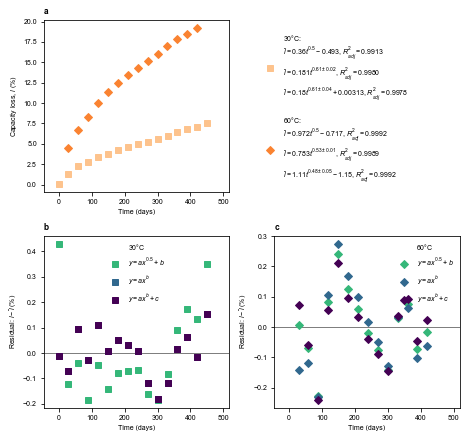

In [18]:
colors = cm.Oranges(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['s','D']

Broussely_labels = Labels(legend_labels = [r'$30\degree$'+'C',r'$60\degree$'+'C'],
                          x_label = 'Time (days)',
                          y_label = 'Capacity loss, ' + r'$l$',
                          dataset_name = 'Broussely',
                          y_symbol = 'l',
                          y_symbol_pred = r'\hat{l}',
                          y_unit = '(%)',
                          switch_xy = True,
                          square_x = False)

plot_dataset(Broussely_data, Broussely_labels)

### Wright et al
[Link to paper](https://doi.org/10.1016/S0378-7753(02)00210-0)

The 60&deg;C data was hard to extract, so we extract all but that one.
<br>
<img src="wright/Wright_et_al_2002_Fig1.png" width="600">

In [19]:
Wright_data = load_dataset('Wright')

['Wright/Wright_et_al_2002_Fig1_40C.csv', 'Wright/Wright_et_al_2002_Fig1_50C.csv', 'Wright/Wright_et_al_2002_Fig1_70C.csv']


Convert ohms to milliohms to improve figure readability:

In [20]:
for k in range(len(Wright_data)):
    Wright_data[k][:,1] *= 1000

x_max of dataset = 27.016774772196914


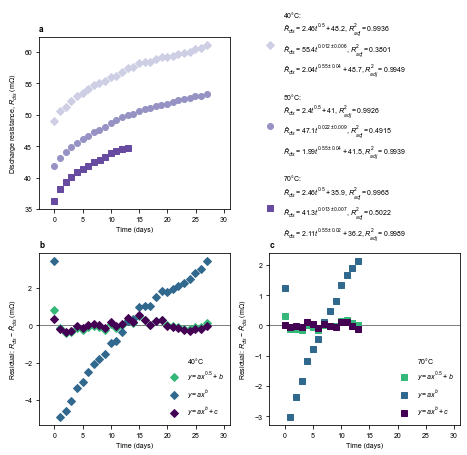

In [21]:
colors = cm.Purples(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['D','o','s']

Wright_labels = Labels(legend_labels = [r'$40\degree$'+'C',r'$50\degree$'+'C',r'$70\degree$'+'C'],
                       x_label = 'Time (days)',
                       y_label = r'Discharge resistance, $R_{dis}$',
                       dataset_name = 'Wright',
                       y_symbol = 'R_{dis}',
                       y_symbol_pred = r'\hat{R}_{dis}',
                       y_unit = r'(m$\Omega$)',
                       switch_xy = False,
                       square_x = True)

plot_dataset(Wright_data, Wright_labels)

### Smith et al.

We now look at the rest of the C/10 data in Figure 7 of Smith et al.

We don't use the dataset loading helper function since we just want to load the new Smith et al csvs

In [22]:
# Load other Smith et al csvs
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_[!30]*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

print(csvs)

Smith_data = []
Smith_data.append(Smith_30C_data[0]) # 30 deg C

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv,delimiter=',')
    Smith_data.append(d)

['smith/Smith_et_al_2011_Fig7_40degC_Cover10.csv', 'smith/Smith_et_al_2011_Fig7_50degC_Cover10.csv']


Plot results:

x_max of dataset = 397.0155552286443


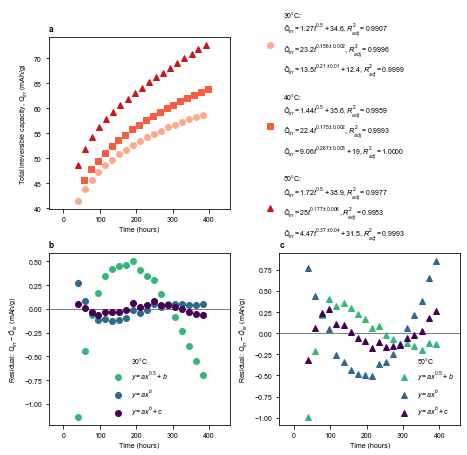

In [23]:
colors = cm.Reds(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['o','s','^']

Smith_labels = Labels(legend_labels = [r'$30\degree$'+'C',r'$40\degree$'+'C',r'$50\degree$'+'C'], 
                      x_label = 'Time (hours)',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'Smith',
                      y_symbol = 'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = True)

plot_dataset(Smith_data, Smith_labels)

### Smith et al (paper 2)
[Link to paper](https://doi.org/10.1149/1.3625232)

We analyze the data in Figure 8b
<br>
<img src="smith2/Smith2_et_al_2011_Fig8.png" width="600">

In [24]:
Smith2_data = load_dataset('Smith2')

['Smith2/Smith2_et_al_2011_Fig8b.csv']


Manual intervention:
1. For the $x$ axis, we can calculate cycle number directly instead of using the values from WebPlotDigitizer
2. For the $y$ axis, we can calculate percent capacity fade to obtain an increasing function (for consistency with other datasets). Using percent capacity fade (as opposed to fractional capacity fade) gives us more readable plots

In [25]:
Smith2_data[0][:,0] = np.arange(len(Smith2_data[0][:,1])) + 1
Smith2_data[0][:,1] = 100*(1 - Smith2_data[0][:,1]/Smith2_data[0][0,1])

In [26]:
colors = np.asarray([[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]])
markers = ['o']

Smith2_labels = Labels(legend_labels = [''], 
                      x_label = 'Cycle number',
                      y_label = 'Capacity loss, $l$',
                      dataset_name = 'Smith2',
                      y_symbol = 'l',
                      y_symbol_pred = r'\hat{l}',
                      y_unit = '(%)',
                      switch_xy = False,
                      square_x = False)

Don't use `plot_dataset` function since we only have one series

x_max of dataset = 41.0


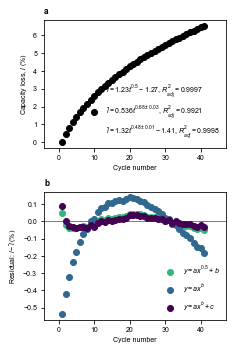

In [27]:
n_datasets = len(Smith2_data)

# Initialize figure
plt.figure(figsize=(fig_width, fig_height*2))

# (a): Plot raw data
ax = plt.subplot(211)
plt.title('a', loc='left', weight='bold')
xlim = plot_raw_data_subplot(Smith2_data, Smith2_labels, markers)
ax.legend()

## Plot first series
plt.subplot(212)
plt.title('b',loc='left',weight='bold')
plot_residual_subplot(Smith2_data, 0, Smith2_labels, xlim, markers[0])
    
min_y = plt.gca().get_ylim()[0]
plt.annotate(Smith2_labels.legend_labels[0], xy=((xlim[1]-5)/2, min_y), xytext=(0, 3),
             textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
figure_filename = 'figures/{}.eps'.format(Smith2_labels.dataset_name)
plt.savefig(figure_filename, bbox_inches='tight', format='eps')

### Fathi et al
[Link to paper](https://doi.org/10.1149/2.0321410jes)

Because this plot was saved as a vector plot, we can more easily extract the data. (I <3 vector formats!)

Here, we focus on Groups 3 and 4 since they have the most data. We extract the data from Figure 2a since the *x* axis units are time, but we replot the data in the format of Figure 2b (and convert to units of percent).
<br>
<img src="fathi/Fathi_et_al_2014_Fig2.png" width="400">

In [28]:
Fathi_data = load_dataset('Fathi')

['Fathi/Fathi_et_al_2014_Fig2a_group3a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group3b.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4b.csv']


The plot gets pretty crowded with all four datasets. I just use one series from each group:

In [29]:
del Fathi_data[1:3]

Also convert this dataset to an increasing function, with nice values (%)

In [30]:
for d in Fathi_data:
    d[:,1] = 100*(1 - d[:,1])

x_max of dataset = 10.946496253391967


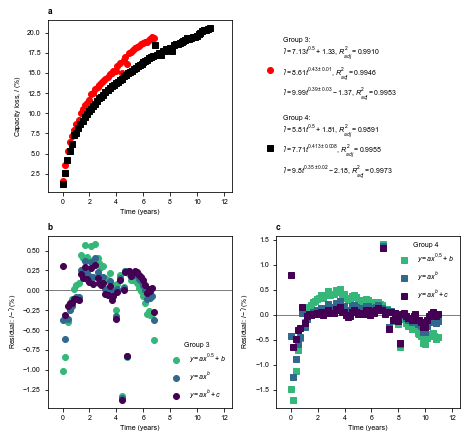

In [31]:
colors = np.asarray([[1, 0, 0],
                     [0, 0, 0]])
markers = ['o','s']

Fathi_labels = Labels(legend_labels = ['Group 3', 'Group 4'],
                      x_label = 'Time (years)',
                      y_label = 'Capacity loss, $l$',
                      dataset_name = 'Fathi',
                      y_symbol = 'l',
                      y_symbol_pred = r'\hat{l}',
                      y_unit = '(%)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(Fathi_data, Fathi_labels)

### Carbon black

This is data that I've collected on carbon black/Li half cells. First we preprocess the raw data:

['carbon black/cellA_Cover20_CB5.txt', 'carbon black/cellH_Cover20_CC2.txt', 'carbon black/cellI_Cover20_CC3.txt']


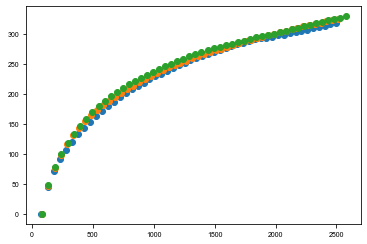

In [32]:
author = 'carbon black'
txts = glob.glob(author + '/*.{}'.format('txt'))
txts.sort(key=sortKeyFunc)
print(txts)

# Divide by masses to get mAh/g
mass = [0.855,0.930,0.952] # cells A, H, I respectively

# Switch order for more natural ordering
txts[0], txts[1] = txts[1], txts[0]
mass[0], mass[1] = mass[1], mass[0] 

time = []
SEI = []
CB_data_time = []
CB_data_cyclenum = []
CB_data_time_subfirstcycle = []
CB_data_cyclenum_subfirstcycle = []

for k, txt in enumerate(txts):
    d = np.genfromtxt(txt,skip_header=1)
    m = mass[k]/1000 # mg -> g
    
    #Q
    Q = d[:,2]/m # mAh -> mAh/g

    # Qd and Qc vs n
    peaks = find_peaks(Q)[0]
    Qpeaks = Q[peaks]
    Qd = Qpeaks[0::2]
    Qc = Qpeaks[1::2]
    
    # t (all cells cycle at C/20, with 1C = 200 mA/g -> C/20 = 10 mA/g)
    t_k = np.cumsum(Qpeaks)/10 # t = Q/I; (mAh/g / mA/g) -> h
    t_k = t_k[1::2]
    
    SEI_k = np.cumsum(Qd[:-1] - Qc)
    
    time.append(t_k) # time per cycle counts after discharge
    SEI.append(SEI_k)
    CB_data_time.append(np.vstack((t_k, SEI_k)).T)
    
    # Compute x as cycle number
    cyclenum_k = np.arange(len(SEI_k)) + 1
    CB_data_cyclenum.append(np.vstack((cyclenum_k, SEI_k)).T)
    
    SEI_k -= SEI_k[0]
    CB_data_time_subfirstcycle.append(np.vstack((t_k, SEI_k)).T)
    CB_data_cyclenum_subfirstcycle.append(np.vstack((cyclenum_k, SEI_k)).T)
    
    plt.plot(time[k],SEI[k],'o')

#### $Q_{SEI}$ vs time

x_max of dataset = 2574.619326000898


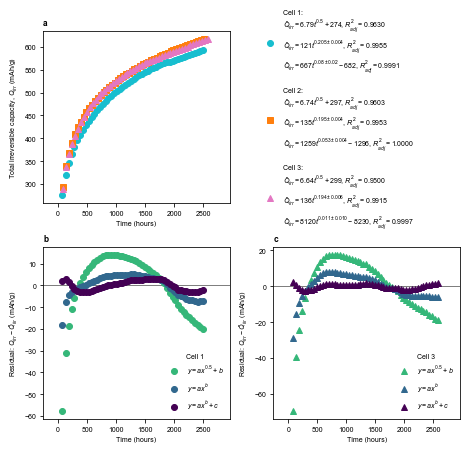

In [33]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels_time = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                        x_label = 'Time (hours)',
                        y_label = 'Total irreversible capacity, $Q_{irr}$',
                        dataset_name = 'CB_time',
                        y_symbol = r'Q_{irr}',
                        y_symbol_pred = r'\hat{Q}_{irr}',
                        y_unit = '(mAh/g)',
                        switch_xy = False,
                        square_x = False)

plot_dataset(CB_data_time, CB_labels_time)

#### $Q_{SEI}$ vs time (subtracted first cycle)

x_max of dataset = 2574.619326000898


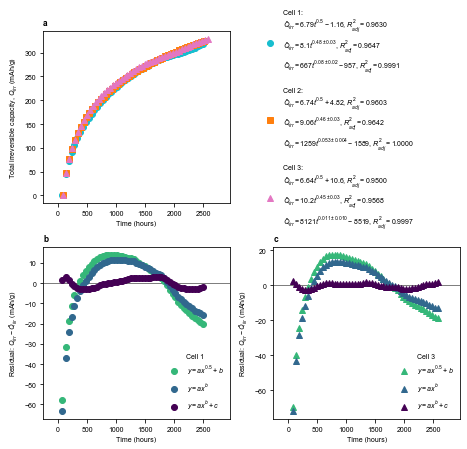

In [34]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels_time_subfirstcycle = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                                      x_label = 'Time (hours)',
                                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                                      dataset_name = 'CB_time_subfirstcycle',
                                      y_symbol = r'Q_{irr}',
                                      y_symbol_pred = r'\hat{Q}_{irr}',
                                      y_unit = '(mAh/g)',
                                      switch_xy = False,
                                      square_x = False)

plot_dataset(CB_data_time_subfirstcycle, CB_labels_time_subfirstcycle)

#### $Q_{SEI}$ vs cycle number

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


x_max of dataset = 51.0


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


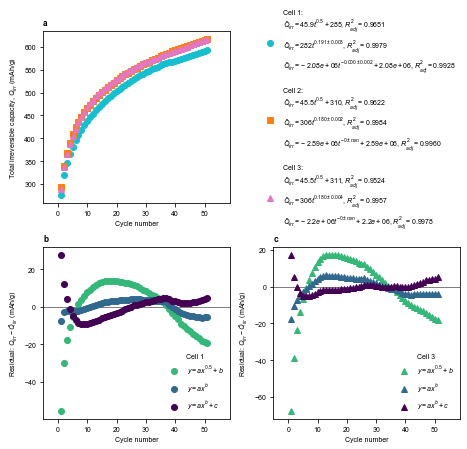

In [35]:
colors = ['tab:cyan','tab:orange','tab:pink']
markers = ['o','s','^']

CB_labels_cyclenum = Labels(legend_labels = ['Cell 1', 'Cell 2', 'Cell 3'],
                      x_label = 'Cycle number',
                      y_label = 'Total irreversible capacity, $Q_{irr}$',
                      dataset_name = 'CB_cyclenum',
                      y_symbol = r'Q_{irr}',
                      y_symbol_pred = r'\hat{Q}_{irr}',
                      y_unit = '(mAh/g)',
                      switch_xy = False,
                      square_x = False)

plot_dataset(CB_data_cyclenum, CB_labels_cyclenum)

### Carbon black data: storage

A late addition to this paper, requested in review: Carbon black data during storage.
Fortunately I collected this data a long time ago (the experiments are very long).

This method is a bit unique. To our knowledge, a variant was first proposed by [Levi et al](https://doi.org/10.1149/1.1697411). We'll need to do a bit of processing first:

In [36]:
colors = colors = cm.Greens(np.linspace(0.3, 1, 4))
colors = colors[:, 0:3]
labels = ['1.5 pre-cycles', '2.5 pre-cycles', '9.5 pre-cycles', '50.5 pre-cycles']

In [37]:
rename_dict =  {'time/h': 'Time (h)',
                'Ecell/V': 'Voltage (V)',
                '(Q-Qo)/mA.h/g': 'Capacity (mAh/g)'}

data_1pt5cycles = pd.read_csv('carbon black storage/1pt5 cycles.csv').rename(columns=rename_dict)
data_2pt5cycles = pd.read_csv('carbon black storage/2pt5 cycles.csv').rename(columns=rename_dict)
data_9pt5cycles = pd.read_csv('carbon black storage/9pt5 cycles.csv').rename(columns=rename_dict)
data_50pt5cycles = pd.read_csv('carbon black storage/50pt5 cycles.csv').rename(columns=rename_dict)

In [38]:
data_1pt5cycles.head()

,Time (h),Voltage (V),Capacity (mAh/g)
0,0.000000,2.42560,0.0
1,0.083333,2.42508,0.0
2,0.166667,2.42304,0.0
3,0.250000,2.42103,0.0
4,0.333333,2.41792,0.0


Consolidate data:

In [39]:
data = [data_1pt5cycles, data_2pt5cycles, data_9pt5cycles, data_50pt5cycles]

Initial visualization of voltage:

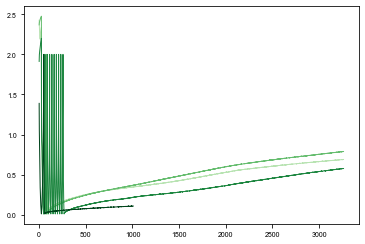

In [40]:
for k, d in enumerate(data):
    plt.plot(d['Time (h)'], d['Voltage (V)'], color=colors[k])

Initial visualization of capacity:

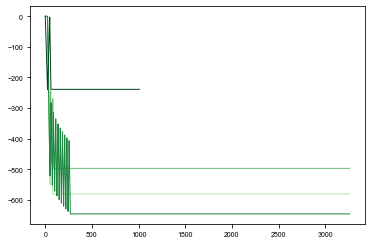

In [41]:
for k, d in enumerate(data):
    plt.plot(d['Time (h)'], d['Capacity (mAh/g)'], color=colors[k])

Find V(t) for self-delithiation:

Text(0, 0.5, 'Voltage (V)')

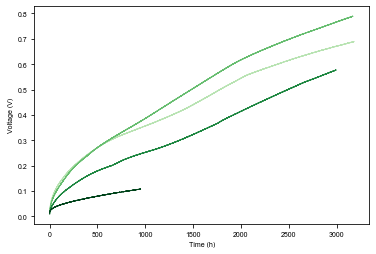

In [42]:
rest_data_V_vs_t = []

for k, d in enumerate(data):
    final_capacity = d['Capacity (mAh/g)'].iloc[-1]
    
    d_rest = d[d['Capacity (mAh/g)'] == final_capacity]
    
    rest_time_zeroed = ( d_rest['Time (h)'] - d_rest['Time (h)'].iloc[0] ).values
    rest_voltage = d_rest['Voltage (V)'].values
    
    rest_data_V_vs_t.append([rest_time_zeroed, rest_voltage])
    
    plt.plot(rest_time_zeroed, rest_voltage, color=colors[k])
    
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')

Find Q(V) for last delithiation:

Text(0, 0.5, 'Voltage (V)')

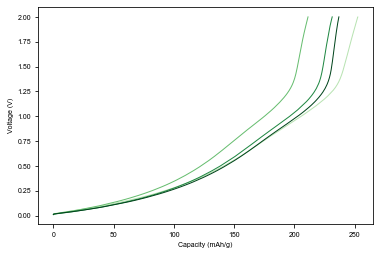

In [43]:
last_delith_Q_vs_V = []

for k, d in enumerate(data):
    peak_loc_pos = find_peaks(d['Capacity (mAh/g)'])[0][-1]
    peak_loc_neg = find_peaks(-d['Capacity (mAh/g)'])[0][-1]
    last_delithiation_idx = np.arange(peak_loc_neg, peak_loc_pos)

    Q_last_delith = (d['Capacity (mAh/g)'][last_delithiation_idx] - d['Capacity (mAh/g)'][last_delithiation_idx].iloc[0]).values
    V_last_delith = d['Voltage (V)'][last_delithiation_idx].values
    
    last_delith_Q_vs_V.append([Q_last_delith, V_last_delith])

    plt.plot(Q_last_delith, V_last_delith, color=colors[k])
    
plt.xlabel('Capacity (mAh/g)')
plt.ylabel('Voltage (V)')

We combine V(t) during the self-delithiation with Q(V) during the last delithiation to get Q(V(t)), or Q(t), during the last delithiation.

First let's illustrate both inputs:

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/peter/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


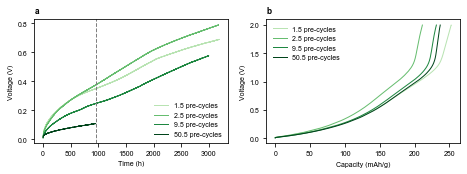

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(fig_width*2, fig_height))

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

min_rest_time = 1e10

for k, (rest, last_delith) in enumerate(zip(rest_data_V_vs_t, last_delith_Q_vs_V)):
    t_rest, V_rest = rest[0], rest[1]
    Q_last_delith, V_last_delith = last_delith[0], last_delith[1]
    
    if t_rest.max() < min_rest_time:
        min_rest_time = t_rest.max()
    
    ax[0].plot(t_rest, V_rest, label=labels[k], color=colors[k])
    ax[1].plot(Q_last_delith, V_last_delith, label=labels[k], color=colors[k])
    
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Voltage (V)')
    ax[0].legend()
    
    ax[1].set_xlabel('Capacity (mAh/g)')
    ax[1].set_ylabel('Voltage (V)')
    ax[1].legend()

ax[0].axvline(min_rest_time, color='tab:gray', ls='--')
plt.tight_layout()
plt.savefig('figures/CB_selfdelith_inputs.eps', bbox_inches='tight', format='eps')

Now combine:

Starting 1.5 pre-cycles
Starting 2.5 pre-cycles
Starting 9.5 pre-cycles
Starting 50.5 pre-cycles


Text(0, 0.5, 'Self-delithiation capacity lost to SEI (mAh/g)')

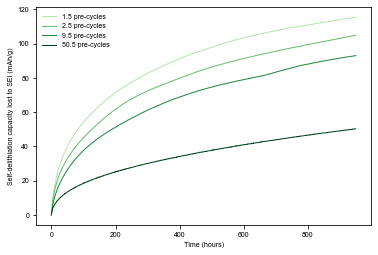

In [45]:
self_delith_Q_vs_t = []
downsampling_ratio = 50

for k, (rest, last_delith) in enumerate(zip(rest_data_V_vs_t, last_delith_Q_vs_V)):
    print(f'Starting {labels[k]}')
    
    t_rest, V_rest = rest[0], rest[1]
    Q_last_delith, V_last_delith = last_delith[0], last_delith[1]
    
    # Remove negative values of Q(V), which is required for interpolation
    V_last_delith2 = V_last_delith[:-1][np.diff(V_last_delith) > 0]
    Q_last_delith2 = Q_last_delith[:-1][np.diff(V_last_delith) > 0]
    
    # Fit Q(V)
    Q_V = interpolate.interp1d(V_last_delith2, Q_last_delith2, kind='cubic')
    
    # Evaluate Q_rest
    idx = (V_rest > V_last_delith2.min()) & (t_rest < min_rest_time)
    t_rest = t_rest[idx][::downsampling_ratio]
    V_rest = V_rest[idx][::downsampling_ratio]
    Q_rest = Q_V(V_rest)
    
    # Append data
    self_delith_Q_vs_t.append(np.vstack((t_rest, Q_rest)).T)
    
    plt.plot(t_rest, Q_rest, label=labels[k], color=colors[k])

plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Self-delithiation capacity lost to SEI (mAh/g)')

#### $Q_{selfdelith}$ vs time

x_max of dataset = 948.7909999999999


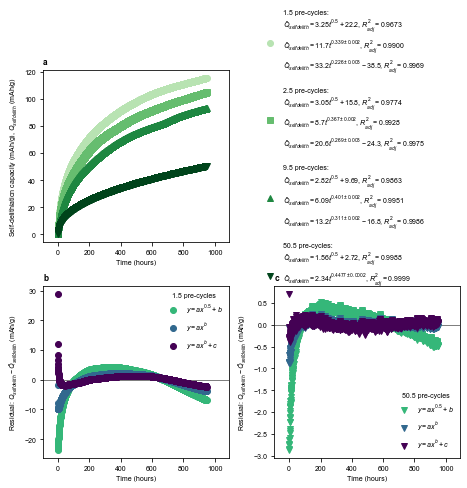

In [46]:
markers = ['o','s','^','v']

CB_labels_selfdelith = Labels(legend_labels = labels,
                              x_label = 'Time (hours)',
                              y_label = 'Self-delithiation capacity (mAh/g), $Q_{selfdelith}$',
                              dataset_name = 'CB_selfdelith_all',
                              y_symbol = r'Q_{selfdelith}',
                              y_symbol_pred = r'\hat{Q}_{selfdelith}',
                              y_unit = '(mAh/g)',
                              switch_xy = False,
                              square_x = False)

plot_dataset(self_delith_Q_vs_t, CB_labels_selfdelith)

Unfortunately I'll have to remove 2.5 pre-cycles to make the legend fit:

x_max of dataset = 948.7909999999999


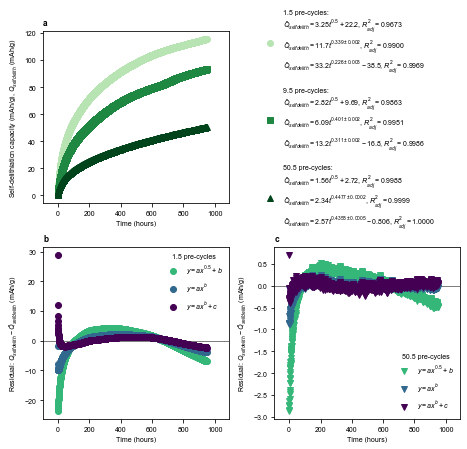

In [47]:
del self_delith_Q_vs_t[1]
del labels[1]
colors = np.delete(colors, 1, axis=0)

CB_labels_selfdelith = Labels(legend_labels = labels,
                              x_label = 'Time (hours)',
                              y_label = 'Self-delithiation capacity (mAh/g), $Q_{selfdelith}$',
                              dataset_name = 'CB_selfdelith',
                              y_symbol = r'Q_{selfdelith}',
                              y_symbol_pred = r'\hat{Q}_{selfdelith}',
                              y_unit = '(mAh/g)',
                              switch_xy = False,
                              square_x = False)

plot_dataset(self_delith_Q_vs_t, CB_labels_selfdelith)

## Moving window exponent

Does the exponent become closer to 0.5 at later times? Here we see how the exponent changes throughtout four datasets.

Create analysis/plotting utility function:

In [48]:
def plot_moving_window_exponent(dataset, labels, ax, n_points_in_moving_window = 5):
    
    print(f'Starting new dataset: {labels.dataset_name}')
    
    exponent = 1
    if labels.square_x:
        exponent = 2
        
    # Preinitialize
    thresholds = np.arange(len(dataset) - n_points_in_moving_window + 1)
    exponent2 = np.zeros(thresholds.size)
    error2 = np.zeros(thresholds.size)
    exponent3 = np.zeros(thresholds.size)
    error3 = np.zeros(thresholds.size)
    
    # Loop through and fit
    for k, threshold in enumerate(thresholds):
        
        # define subset
        x_subset = dataset[threshold:threshold + n_points_in_moving_window,0]**exponent
        y_subset = dataset[threshold:threshold + n_points_in_moving_window,1]
        
        if labels.switch_xy:
            x_subset, y_subset = y_subset, x_subset

        # fit subset
        popt, CIs, R2 = curve_fit_with_adj_r_squared(power1, x_subset, y_subset)
        exponent2[k] = popt[1]
        error2[k] = CIs[1]

        popt, CIs, R2 = curve_fit_with_adj_r_squared(power2, x_subset, y_subset, maxfev=500000)
        exponent3[k] = popt[1]
        error3[k] = CIs[1]
    
    # log results
    print('2-param fit: mean(b) = {:.3f}, std(b) = {:.3f}'.format(np.mean(exponent2), np.std(exponent2)))
    print('3-param fit: mean(b) = {:.3f}, std(b) = {:.3f}'.format(np.mean(exponent3), np.std(exponent3)))
    
    # Plotting prep
    colors = cm.viridis(np.linspace(0, 1, 4))
    colors = colors[:,0:3]
    
    # Convert number to word for x axis
    n_points_in_moving_window_word = inflect.engine().number_to_words(n_points_in_moving_window)
    
    # Plot
    ax.errorbar(thresholds, exponent2, error2, fmt='<', color=colors[1,:], label=r'$'+labels.y_symbol_pred+'=ax^b$')
    ax.errorbar(thresholds, exponent3, error3, fmt='>', color=colors[0,:], label=r'$'+labels.y_symbol_pred+'=ax^b+c$')
    ax.set_xlabel(f'Index of first point used in {n_points_in_moving_window_word}-point moving window')
    ax.set_ylabel('Exponent (' + r'$b$' + ') from fits with 95% CI')
    ax.set_ylim((-0.02,1.52))
    ax.legend(frameon=True, framealpha=1)

Try for four datasets:


Starting 5 points
Starting new dataset: Broussely


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.531, std(b) = 0.030
3-param fit: mean(b) = 0.493, std(b) = 0.436
Starting new dataset: Smith
2-param fit: mean(b) = 0.157, std(b) = 0.004
3-param fit: mean(b) = 0.180, std(b) = 0.135
Starting new dataset: Smith2


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.702, std(b) = 0.169
3-param fit: mean(b) = 0.541, std(b) = 0.457
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.426, std(b) = 0.135
3-param fit: mean(b) = 11.000, std(b) = 47.952

Starting 6 points
Starting new dataset: Broussely
2-param fit: mean(b) = 0.527, std(b) = 0.024
3-param fit: mean(b) = 0.510, std(b) = 0.307
Starting new dataset: Smith
2-param fit: mean(b) = 0.157, std(b) = 0.004
3-param fit: mean(b) = 0.162, std(b) = 0.097
Starting new dataset: Smith2
2-param fit: mean(b) = 0.695, std(b) = 0.149
3-param fit: mean(b) = 0.467, std(b) = 0.262
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.426, std(b) = 0.118
3-param fit: mean(b) = 10.052, std(b) = 47.537

Starting 7 points
Starting new dataset: Broussely
2-param fit: mean(b) = 0.524, std(b) = 0.019
3-param fit: mean(b) = 0.529, std(b) = 0.235
Starting new dataset: Smith
2-param fit: mean(b) = 0.158, std(b) = 0.003
3-param fit: mean(b) = 0.156, std(b) = 0.088
Starting new dataset: Smith2
2-param fit: mean(b) = 0.689, std(b) = 0.135
3-param fit: mean(b) = 0.457, std(b) = 0.195
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.427, std(b) = 0.104
3-param fit: mean(b) = 1.964, std(b) = 4.675

Starting 8 points
Starting new dataset: Broussely
2-param fit: mean(b) = 0.523, std(b) = 0.014
3-param fit: mean(b) = 0.526, std(b) = 0.190
Starting new dataset: Smith
2-param fit: mean(b) = 0.158, std(b) = 0.003
3-param fit: mean(b) = 0.158, std(b) = 0.086
Starting new dataset: Smith2
2-param fit: mean(b) = 0.685, std(b) = 0.124
3-param fit: mean(b) = 0.456, std(b) = 0.178
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value enco

2-param fit: mean(b) = 0.427, std(b) = 0.094
3-param fit: mean(b) = 0.878, std(b) = 1.801

Starting 9 points
Starting new dataset: Broussely
2-param fit: mean(b) = 0.522, std(b) = 0.011
3-param fit: mean(b) = 0.512, std(b) = 0.141
Starting new dataset: Smith
2-param fit: mean(b) = 0.158, std(b) = 0.003
3-param fit: mean(b) = 0.155, std(b) = 0.080
Starting new dataset: Smith2
2-param fit: mean(b) = 0.682, std(b) = 0.115
3-param fit: mean(b) = 0.452, std(b) = 0.128
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.428, std(b) = 0.086
3-param fit: mean(b) = 0.990, std(b) = 2.152

Starting 10 points
Starting new dataset: Broussely
2-param fit: mean(b) = 0.523, std(b) = 0.010
3-param fit: mean(b) = 0.493, std(b) = 0.099
Starting new dataset: Smith
2-param fit: mean(b) = 0.158, std(b) = 0.002
3-param fit: mean(b) = 0.158, std(b) = 0.073
Starting new dataset: Smith2
2-param fit: mean(b) = 0.679, std(b) = 0.108
3-param fit: mean(b) = 0.445, std(b) = 0.109
Starting new dataset: Fathi


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


2-param fit: mean(b) = 0.429, std(b) = 0.079
3-param fit: mean(b) = 0.963, std(b) = 1.709


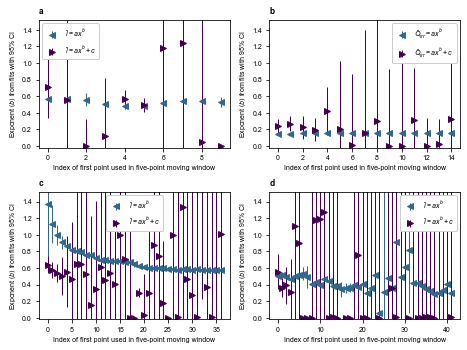

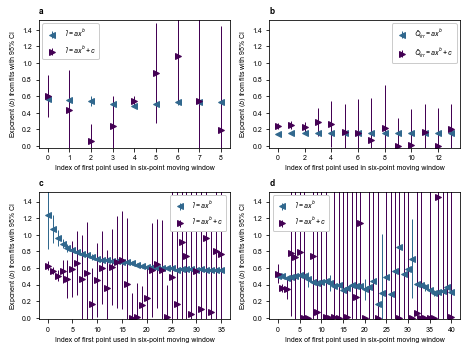

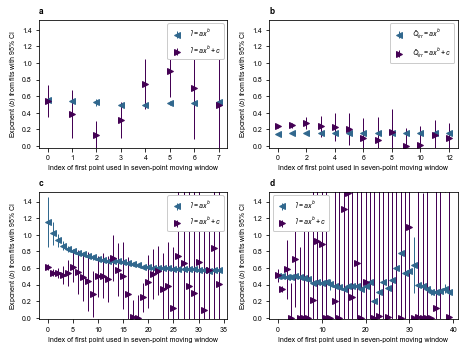

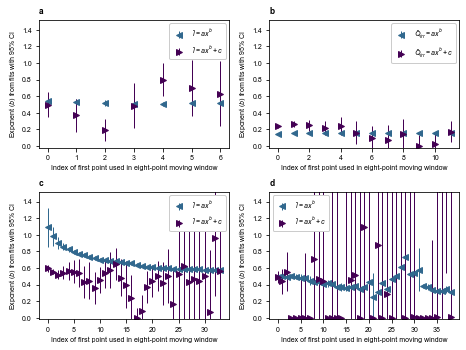

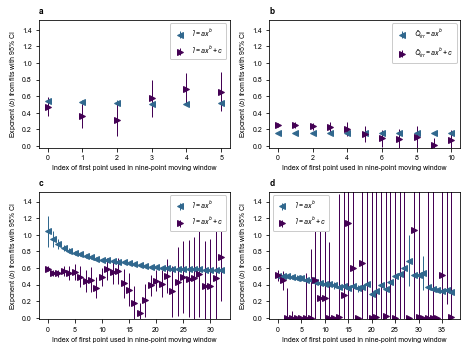

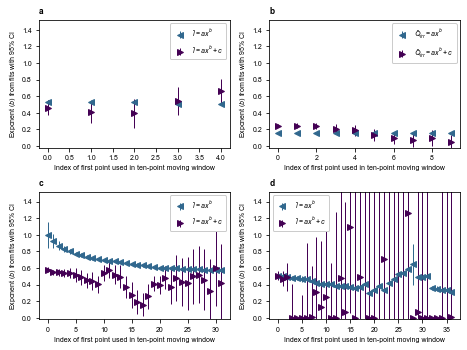

In [49]:
n_points = np.arange(5,11)

for n in n_points:
    print(f'\nStarting {n} points')
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(fig_width*2, fig_height*2))
    ax = ax.ravel()
    
    plot_moving_window_exponent(Broussely_data[1], Broussely_labels, ax[0], n_points_in_moving_window = n)
    plot_moving_window_exponent(Smith_30C_data[0], Smith_labels, ax[1], n_points_in_moving_window = n)
    plot_moving_window_exponent(Smith2_data[0], Smith2_labels, ax[2], n_points_in_moving_window = n)
    plot_moving_window_exponent(Fathi_data[0], Fathi_labels, ax[3], n_points_in_moving_window = n)

    for k in range(4):
        ax[k].set_title(chr(97+k), loc='left', weight='bold')

    plt.tight_layout()
    plt.savefig(f'figures/moving_window_exponent_{n}_points.eps', bbox_inches='tight', format='eps')

## Prediction
As an example, try prediction of last 20% of data points, using first 80% of data points for training. First make a function to return prediction intervals ( nice discussion of prediction intervals is [here](https://otexts.com/fpp2/forecasting-regression.html#eq:Regr-pi)):

In [50]:
def curve_fit_with_PIs(f, xdata, ydata, x_pred, maxfev=10000):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=maxfev)

    n = len(xdata)
    p = len(popt)
    
    # confidence intervals of the fitted parameters
    CIs = tval(alpha, n, p) * np.diag(pcov)**0.5
    
    x_mean = np.mean(xdata)
    x_std = np.std(xdata)
    
    se_reg = np.sqrt(np.sum((ydata - f(xdata, *popt))**2) / (n - p - 1))
    
    # prediction intervals of future y values
    PIs = tval(alpha, n, p) * se_reg * np.sqrt(1 + 1/n + (x_pred - x_mean)**2 / ((n-1) * x_std**2) )
    
    return popt, CIs, PIs

Split into train/test and fit:

In [51]:
training_fraction = 0.8 # 80% for training
threshold = int(np.floor(len(x)*training_fraction)) # train/test threshold for indexing

# split into test/train
x_train = Smith_30C_data[0][:threshold,0]**2
y_train = Smith_30C_data[0][:threshold,1]
x_test = Smith_30C_data[0][threshold:,0]**2
y_test = Smith_30C_data[0][threshold:,1]

x_boundary = np.max(x_train) + (np.min(x_test) - np.max(x_train)) / 2
x_fitting = np.linspace(np.min(x_train), x_boundary, 1000)
x_future = np.linspace(x_boundary, 1000, 1000)

# fit training data
popt1, CIs1, PIs1 = curve_fit_with_PIs(t_onehalf, x_train, y_train, x_future)
popt2, CIs2, PIs2 = curve_fit_with_PIs(power1, x_train, y_train, x_future)
popt3, CIs3, PIs3 = curve_fit_with_PIs(power2, x_train, y_train, x_future)

# calculate rmse
rmse1 = np.sqrt(mean_squared_error(y_test, t_onehalf(x_test, *popt1)))
rmse2 = np.sqrt(mean_squared_error(y_test, power1(x_test, *popt2)))
rmse3 = np.sqrt(mean_squared_error(y_test, power2(x_test, *popt3)))

print('RMSE for at^1/2+b: %.4f' % rmse1)
print('RMSE for at^b: %.4f' % rmse2)
print('RMSE for at^b+c: %.4f' % rmse3)

RMSE for at^1/2+b: 1.0360
RMSE for at^b: 0.0889
RMSE for at^b+c: 0.1399


The RMSE of the last model is ~10x smaller than that of the first model.

Plot the results:

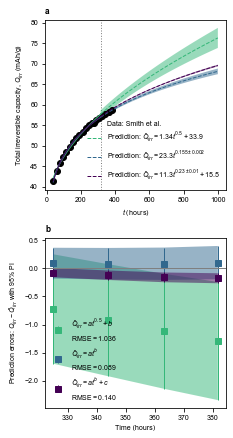

In [52]:
x = Smith_30C_data[0][:,0]**2 # work with x in units of time, not sqrt(time)
y = Smith_30C_data[0][:,1]

# Plotting prep
colors = cm.viridis(np.linspace(0, 1, 4))
colors = colors[:,0:3]

plt.subplots(figsize=(fig_width, fig_height*2.5), nrows=2)

## PANEL A
plt.subplot(211)
plt.title('a', loc='left', weight='bold')

# x axis line denoting boundary between x_train and x_test
plt.axvline(np.mean(x[threshold-1:threshold+1]), color='tab:gray', linestyle=':', zorder=0)

# 95% PIs
plt.fill_between(x_future, t_onehalf(x_future, *popt1) - PIs1, t_onehalf(x_future, *popt1) + PIs1, facecolor=colors[2,:], alpha=0.5)
plt.fill_between(x_future, power1(x_future, *popt2) - PIs2, power1(x_future, *popt2) + PIs2, facecolor=colors[1,:], alpha=0.5)
plt.fill_between(x_future, power2(x_future, *popt3) - PIs3, power2(x_future, *popt3) + PIs3, facecolor=colors[0,:], alpha=0.5)

# Data
plt.plot(x, y, 'ko', label='Data: Smith et al.')

# Fits to training
plt.plot(x_fitting, t_onehalf(x_fitting, *popt1), color=colors[2,:])
plt.plot(x_fitting, power1(x_fitting, *popt2), color=colors[1,:])
plt.plot(x_fitting, power2(x_fitting, *popt3), color=colors[0,:])

# Extrapolations
plt.plot(x_future, t_onehalf(x_future, *popt1), '--', color=colors[2,:],
         label='Prediction: ' + r'$\hat{Q}_{irr}=%.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x_future, power1(x_future, *popt2), '--', color=colors[1,:],
         label='Prediction: ' + r'$\hat{Q}_{irr}=%.1ft^{%5.3f \pm %5.3f}$' % tuple(np.append(popt2, CIs2[1])))
plt.plot(x_future, power2(x_future, *popt3), '--', color=colors[0,:],
         label='Prediction: ' + r'$\hat{Q}_{irr}=%.1ft^{%5.2f \pm %5.2f} + %5.1f$' % tuple(np.insert(popt3, 2, CIs3[1])))

plt.xlabel(r'$t$' + ' (hours)')
plt.ylabel('Total irreversible capacity, $Q_{irr}$ (mAh/g)')
plt.legend(framealpha=1, edgecolor='white').set_zorder(1)

## PANEL B
plt.subplot(212)
plt.title('b', loc='left', weight='bold')

# Find prediction points in 95% CI
idx = [np.argmax(x_future > x_test[k]) for k in range(len(x_test))]

# 95% PI
plt.fill_between(x_test, y_test - t_onehalf(x_test, *popt1) - PIs1[idx], y_test - t_onehalf(x_test, *popt1) + PIs1[idx], facecolor=colors[2,:], alpha=0.5)
plt.fill_between(x_test, y_test - power1(x_test, *popt2) - PIs2[idx], y_test - power1(x_test, *popt2) + PIs2[idx], facecolor=colors[1,:], alpha=0.5)
plt.fill_between(x_test, y_test - power2(x_test, *popt3) - PIs3[idx], y_test - power2(x_test, *popt3) + PIs3[idx], facecolor=colors[0,:], alpha=0.5)

# Predicted points with PIs
plt.axhline(0, color='tab:gray')
plt.errorbar(x_test, y_test - t_onehalf(x_test, *popt1), yerr=PIs1[idx], fmt='s', color=colors[2,:],
         label=r'$\hat{Q}_{irr}=at^{0.5}+b$' + '\nRMSE' + r'$=%3.3f$' %(rmse1))
plt.errorbar(x_test, y_test - power1(x_test, *popt2), yerr=PIs2[idx], fmt='s', color=colors[1,:],
         label=r'$\hat{Q}_{irr}=at^{b}$' + '\nRMSE' + r'$=%3.3f$' %(rmse2))
plt.errorbar(x_test, y_test - power2(x_test, *popt3), yerr=PIs3[idx], fmt='s', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$' + '\nRMSE' + r'$=%3.3f$' %(rmse3))

plt.xlabel('Time (hours)')
plt.ylabel('Prediction errors: ' + r'$Q_{irr}-\hat{Q}_{irr}$ with 95% PI')
plt.legend()

plt.tight_layout()

# the transparency is important, but not supported by eps, so save to pdf
plt.savefig('figures/Smith_30C_predictions.pdf',bbox_inches='tight',format='pdf')

How much does $t^{0.5}$ overestimate the degradation by relative to the two-term model?

In [53]:
# Absolute difference
Qirr_1000hr_tonehalf = t_onehalf(1000, *popt1)
Qirr_1000hr_power1 = power1(1000, *popt2)
print('Absolute difference:')
print(f'Qirr, at^(0.5)+b, 1000 hours: {Qirr_1000hr_tonehalf:.2f} mAh/g')
print(f'Qirr, at^(b), 1000 hours: {Qirr_1000hr_power1:.2f} mAh/g')
print(f'Relative increase: {100 * Qirr_1000hr_tonehalf/Qirr_1000hr_power1 - 100:.1f}%')

# Relative difference
Qirr_1000hr_tonehalf = t_onehalf(1000, *popt1) - t_onehalf(x_boundary, *popt1)
Qirr_1000hr_power1 = power1(1000, *popt2) - power1(x_boundary, *popt2)
print('\nRelative difference:')
print(f'Qirr, at^(0.5)+b, 1000 hours: {Qirr_1000hr_tonehalf:.2f} mAh/g')
print(f'Qirr, at^(b), 1000 hours: {Qirr_1000hr_power1:.2f} mAh/g')
print(f'Relative increase: {100 * Qirr_1000hr_tonehalf/Qirr_1000hr_power1 - 100:.1f}%')

Absolute difference:
Qirr, at^(0.5)+b, 1000 hours: 76.26 mAh/g
Qirr, at^(b), 1000 hours: 68.12 mAh/g
Relative increase: 12.0%

Relative difference:
Qirr, at^(0.5)+b, 1000 hours: 18.60 mAh/g
Qirr, at^(b), 1000 hours: 11.18 mAh/g
Relative increase: 66.4%


## Test different functional forms
Here we try nine different functional forms for the $30^{\circ} C$ data of Smith et al., with two objectives:
1. Are there any functional forms that do not exhibit a systematic trend in their residuals?
2. Do any of the 95% CIs of the exponents of the exponential functional forms contain 0.5 in their CIs?

This is an SI figure

Nine functional forms here:

In [54]:
functional_forms = [lambda x, a:          a * x**0.5,
                    lambda x, a, c:       a * x**0.5 + c,
                    lambda x, a, b:       a * x**b,
                    lambda x, a, b, c:    a * x**b + c,
                    lambda x, a, b, c:    a * (x + c)**b,
                    lambda x, a, b, c, d: a * (x + c)**b + d,
                    lambda x, a, b:       a * np.log(x + b),
                    lambda x, a, b:       a * np.log(x) + b,
                    lambda x, a, b, c:    a * np.log(x + b) + c]

Math text representation:

In [55]:
functional_form_titles = ['$at^{0.5}$',
                          '$at^{0.5} + c$',
                          '$at^{b}$',
                          '$at^{b} + c$',
                          '$a(t+c)^{b}$',
                          '$a(t+c)^{b} + d$',
                          '$a\log(t + b)$',
                          '$a\log(t) + b$',
                          '$a\log(t + b) + c$']

Some hardcoding to make the exponents appear with significant figures:

In [56]:
idx_functional_forms_with_exponent = [2, 3, 4, 5] # all functional forms with exponent
sigfigs_str = {2:'; $b=%.3f \pm %.3f$', # hardcoded
               3:'; $b=%.2f \pm %.2f$',
               4:'; $b=%.3f \pm %.3f$',
               5:'; $b=%.2f \pm %.2f$'}

Fit and plot:

0, [3.56961933], 9.320, -2.7016
1, [ 1.27206726 34.60392196], 0.452, 0.9907
2, [23.23709081  0.15591525], 0.092, 0.9996
3, [13.54075315  0.20711713 12.43957338], 0.043, 0.9999
4, [22.06756355  0.16438865  6.91821437], 0.034, 0.9999
5, [ 76.8717028    0.0790327   20.24124719 -64.70025325], 0.026, 1.0000
6, [ 9.75065479 31.04712438], 0.034, 0.9999
7, [ 7.81057705 11.90422464], 0.337, 0.9948
8, [ 9.87346669 33.03925074 -0.76461861], 0.031, 1.0000


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


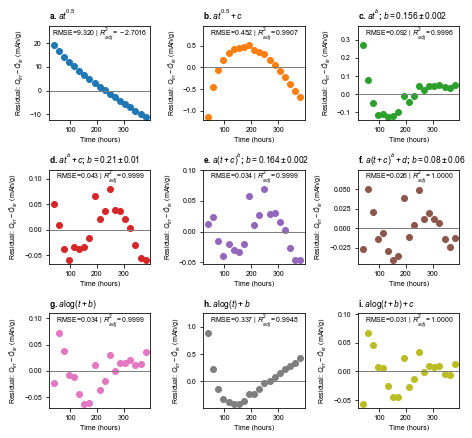

In [57]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
y_label = 'Residual: '+ r'$' + Smith_labels.y_symbol +'-' + Smith_labels.y_symbol_pred + '$' + ' ' + Smith_labels.y_unit

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(fig_width*2, fig_height*2.5))
axes = axes.ravel()

for k, ax in enumerate(axes):
    # Fit each functional form
    popt, CIs, R2adj = curve_fit_with_adj_r_squared(functional_forms[k], x, y)
    
    # Get residuals and RMSE
    y_pred = functional_forms[k](x, *popt)
    residual = y - y_pred
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Print stats
    print(f'{k}, {popt}, {rmse:0.3f}, {R2adj:.4f}')
    
    # Create label and title
    label = f'RMSE={rmse:0.3f}' + ' | ' + r'$R_{adj}^2=%.4f}$' % R2adj
    title = chr(97+k) + '. ' + functional_form_titles[k]
    if k in idx_functional_forms_with_exponent: # add exponent ranges to title
        title += sigfigs_str[k] % (popt[1], CIs[1])
        
    # Plot
    ax.plot(x, residual, 'o', color=colors[k])
    ax.axhline(0, color='tab:gray')
    
    # Title/labels
    ax.set_title(title, loc='left', weight='bold')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel(y_label)
    
    # Adjust ylim
    ylim = ax.get_ylim()
    ylim_range = ylim[1] - ylim[0]
    ax.set_ylim(ylim[0], ylim[1] + 0.2*ylim_range)
    
    # Add annotation
    x_center = 9 * (ax.get_xlim()[1] - ax.get_xlim()[0]) / 16 # slightly off center
    xy = (x_center, ylim[1] + 0.09*ylim_range)
    ax.annotate(label, xy, ha='center', va='center')
    
plt.tight_layout()
plt.savefig('figures/multiple_fits.eps', bbox_inches='tight', format='eps')

It looks like the answer to both questions above is no.